In [ ]:

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

try:
    import torchsde
except ImportError:
    print("Error: torchsde not found. Please install it: pip install torchsde")
    exit()

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings 


warnings.filterwarnings("ignore", category=RuntimeWarning)



SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)









device = torch.device("cpu")
print(f"Using device: {device}")


CSV_FILENAME = "C9_zoomed_interpolated.csv" 


LEARNING_RATE = 1e-3     
NUM_EPOCHS = 1500        
HIDDEN_DIM_NN = 32
SDE_SOLVER_METHOD = 'euler'  
SDE_SOLVER_DT = 1e-2     
NOISE_TYPE = "diagonal"  
BROWNIAN_SIZE = 2        
PRINT_EVERY = 10
WEIGHT_DECAY = 1e-6
GRADIENT_CLIP_MAX_NORM = 1.0 
N_PLOT_SAMPLES = 5         


print(f"\n--- Loading Empirical Data from {CSV_FILENAME} ---")
try:
    df = pd.read_csv(CSV_FILENAME)
    print("CSV loaded successfully.")
    
    time_col = 'time (days)'
    prey_col = 'algae (10^6 cells/ml)'
    predator_col = 'rotifers (animals/ml)'
    required_cols = [time_col, prey_col, predator_col]
    if not all(col in df.columns for col in required_cols):
         print(f"Error: Required columns {required_cols} not found in CSV.")
         print("Available columns:", df.columns.tolist())
         exit()
    print("Required columns found.")
except FileNotFoundError:
    print(f"Error: File not found at {CSV_FILENAME}. Please ensure it's accessible.")
    exit()
except Exception as e:
    print(f"Error loading or reading CSV: {e}")
    exit()


print("\n--- Preparing, Splitting, and Scaling Data (80% Train, 20% Test) ---")


t_data_np_full = df[time_col].values.astype(np.float32)

u_data_np_full = np.maximum(1e-6, df[[prey_col, predator_col]].values).astype(np.float32)

N_POINTS = len(t_data_np_full)
if N_POINTS < 2: print("Error: Not enough data points."); exit()
print(f"Loaded {N_POINTS} data points.")


split_ratio = 0.8
split_idx = int(split_ratio * N_POINTS)
n_train = split_idx
n_test = N_POINTS - n_train

if n_train < 1 or n_test < 1: print("Error: Not enough data for train/test split."); exit()
print(f"Splitting data: {n_train} training points, {n_test} test points.")


t_train_np = t_data_np_full[:split_idx]
u_train_np_orig = u_data_np_full[:split_idx, :] 
t_test_np = t_data_np_full[split_idx:]
u_test_np_orig = u_data_np_full[split_idx:, :]   


print("Scaling data using StandardScaler (fitted on training data)...")
scaler = StandardScaler()

u_train_np_scaled = scaler.fit_transform(u_train_np_orig)
print(f"Scaler Mean: {scaler.mean_}, Scaler Scale: {scaler.scale_}")


t_train = torch.tensor(t_train_np, dtype=torch.float32).to(device) 
u_train = torch.tensor(u_train_np_scaled, dtype=torch.float32).to(device) 
t_data = torch.tensor(t_data_np_full, dtype=torch.float32).to(device)  


u0 = u_train[0].clone().detach().to(device) 

print("Data prepared for PyTorch:")
print(f"  Training time shape: {t_train.shape}, Training data shape (scaled): {u_train.shape}")
print(f"  Test time shape (np):{t_test_np.shape}, Test data shape (orig): {u_test_np_orig.shape}")
print(f"  Initial condition (u0, scaled): {u0.cpu().numpy()}")





class KnownDynamicsDrift(nn.Module):
    def __init__(self, initial_params=None):
        super().__init__()
        if initial_params is None: 
             initial_params = torch.tensor([0.5, 0.1, 0.5, 0.1], dtype=torch.float32)
        self.log_params = nn.Parameter(torch.log(initial_params + 1e-8))

    def forward(self, t, u): 
        if u.ndim == 1: u = u.unsqueeze(0)
        params = torch.exp(self.log_params)
        alpha, beta, gamma, delta = params[0], params[1], params[2], params[3]
        
        algae_scaled = u[:, 0]
        rotifers_scaled = u[:, 1]
        d_algae_scaled = alpha * algae_scaled - beta * algae_scaled * rotifers_scaled
        d_rotifers_scaled = delta * algae_scaled * rotifers_scaled - gamma * rotifers_scaled
        du_dt_scaled = torch.stack([d_algae_scaled, d_rotifers_scaled], dim=1)
        return du_dt_scaled


class NeuralNetworkDrift(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=HIDDEN_DIM_NN, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('tanh'))
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, u): 
         return self.net(u)


class NeuralNetworkDiffusion(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=HIDDEN_DIM_NN, output_dim=2): 
        super().__init__()
        self.input_dim = input_dim
        if NOISE_TYPE == "diagonal": final_output_dim = input_dim
        elif NOISE_TYPE == "scalar": final_output_dim = 1
        elif NOISE_TYPE == "general": final_output_dim = input_dim * BROWNIAN_SIZE
        else: raise ValueError(f"Unknown noise_type: {NOISE_TYPE}")
        self.final_output_dim = final_output_dim

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, final_output_dim) 
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                if m != self.net[-1]: 
                    nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('tanh'))
                    if m.bias is not None: nn.init.zeros_(m.bias)
                else: 
                    nn.init.uniform_(m.weight, a=-0.01, b=0.01)
                    if m.bias is not None: nn.init.constant_(m.bias, 0.0)

    def forward(self, u): 
        return self.net(u)


class SDEDynamics(nn.Module):
    sde_type = "ito"
    noise_type = NOISE_TYPE

    def __init__(self, initial_known_params=None):
        super().__init__()
        self.known_drift = KnownDynamicsDrift(initial_known_params).to(device)
        self.nn_drift = NeuralNetworkDrift().to(device)
        self.nn_diffusion = NeuralNetworkDiffusion().to(device)

    def f(self, t, u): 
        u_nonneg = torch.relu(u) 
        known = self.known_drift(t, u_nonneg)
        nn_drift = self.nn_drift(u_nonneg)
        return known + nn_drift

    def g(self, t, u): 
        u_nonneg = torch.relu(u) 
        return self.nn_diffusion(u_nonneg)


sde_func = SDEDynamics().to(device)
parameters = list(sde_func.parameters())
optimizer = optim.Adam(parameters, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.MSELoss() 


Using device: cpu

--- Loading Empirical Data from C9_zoomed_interpolated.csv ---
CSV loaded successfully.
Required columns found.

--- Preparing, Splitting, and Scaling Data (80% Train, 20% Test) ---
Loaded 200 data points.
Splitting data: 160 training points, 40 test points.
Scaling data using StandardScaler (fitted on training data)...
Scaler Mean: [ 1.35797123 13.43116871], Scaler Scale: [0.70815814 7.00402063]
Data prepared for PyTorch:
  Training time shape: torch.Size([160]), Training data shape (scaled): torch.Size([160, 2])
  Test time shape (np):(40,), Test data shape (orig): (40, 2)
  Initial condition (u0, scaled): [-0.75967675 -0.9724655 ]


In [ ]:

print(f"\n--- Starting Training Neural SDE on Empirical Data ({NUM_EPOCHS} Epochs) ---")
losses = []
min_loss = float('inf')
best_model_state = None
best_epoch = 0
ts_train = t_train 

for epoch in range(1, NUM_EPOCHS + 1):
    sde_func.train()
    optimizer.zero_grad()
    u0_batch = u0.unsqueeze(0) 

    try:
        
        u_pred_train_scaled = torchsde.sdeint(sde_func, u0_batch, ts_train, method=SDE_SOLVER_METHOD, dt=SDE_SOLVER_DT, names={'drift': 'f', 'diffusion': 'g'})
        u_pred_train_scaled = u_pred_train_scaled.squeeze(1) 

        if torch.isnan(u_pred_train_scaled).any() or torch.isinf(u_pred_train_scaled).any():
            print(f"Epoch {epoch}: NaN/Inf detected in prediction. Skipping update.")
            if best_model_state:
                 try: sde_func.load_state_dict(best_model_state); print("  Restored best model state.")
                 except Exception as load_e: print(f"  Failed to restore best model state: {load_e}")
            else: print("  No previous best state to restore.")
            losses.append(float('nan'))
            continue

        
        loss = loss_fn(u_pred_train_scaled, u_train)

        if torch.isnan(loss): print(f"Error: Loss is NaN at epoch {epoch}. Stopping."); break

        loss.backward()
        torch.nn.utils.clip_grad_norm_(parameters, max_norm=GRADIENT_CLIP_MAX_NORM) 
        optimizer.step()
        current_loss = loss.item()
        losses.append(current_loss)

    except Exception as e:
        print(f"Error during training loop at epoch {epoch}: {e}")
        if best_model_state: 
            try: sde_func.load_state_dict(best_model_state); print("Restored best state before stopping.")
            except Exception as load_e: print(f"Failed to restore best state after error: {load_e}")
        break

    
    if epoch % PRINT_EVERY == 0 or epoch == 1:
        if not np.isnan(current_loss):
            print(f"Epoch {epoch}/{NUM_EPOCHS}, Loss (Scaled): {current_loss:.6f}")
            
            with torch.no_grad():
                 current_params = torch.exp(sde_func.known_drift.log_params).cpu().numpy()
                 
                 g_u0 = sde_func.g(ts_train[0], u0_batch)
                 

    
    if not np.isnan(current_loss) and current_loss < min_loss:
        min_loss = current_loss
        best_model_state = sde_func.state_dict()
        best_epoch = epoch


if epoch < NUM_EPOCHS: print(f"--- Training stopped early at epoch {epoch} ---")
else: print("--- Training Complete ---")

if losses and not np.all(np.isnan(losses)): print(f"Final Training Loss (Scaled): {losses[-1]:.6f}")
if best_model_state:
    print(f"Best Training Loss Achieved (Scaled): {min_loss:.6f} at epoch {best_epoch}")
    print("Loading best model state for evaluation...")
    try: sde_func.load_state_dict(best_model_state); print("Best model state loaded.")
    except Exception as e: print(f"Warning: Failed to load best model state: {e}")
else: print("Warning: No valid best model state saved.")




--- Starting Training Neural SDE on Empirical Data (1500 Epochs) ---
Epoch 1/1500, Loss (Scaled): 1.761399
Epoch 10/1500, Loss (Scaled): 1.033188
Epoch 20/1500, Loss (Scaled): 0.898125
Epoch 30/1500, Loss (Scaled): 0.982356
Epoch 40/1500, Loss (Scaled): 0.866859
Epoch 50/1500, Loss (Scaled): 0.875127
Epoch 60/1500, Loss (Scaled): 0.839172
Epoch 70/1500, Loss (Scaled): 0.792230
Epoch 80/1500, Loss (Scaled): 0.709888
Epoch 90/1500, Loss (Scaled): 0.409814
Epoch 100/1500, Loss (Scaled): 0.473875
Epoch 110/1500, Loss (Scaled): 0.236332
Epoch 120/1500, Loss (Scaled): 0.245562
Epoch 130/1500, Loss (Scaled): 0.478096
Epoch 140/1500, Loss (Scaled): 0.484239
Epoch 150/1500, Loss (Scaled): 0.198400
Epoch 160/1500, Loss (Scaled): 0.309092
Epoch 170/1500, Loss (Scaled): 0.390929
Epoch 180/1500, Loss (Scaled): 0.198923
Epoch 190/1500, Loss (Scaled): 0.187787
Epoch 200/1500, Loss (Scaled): 0.932902
Epoch 210/1500, Loss (Scaled): 0.259308
Epoch 220/1500, Loss (Scaled): 0.324308
Epoch 230/1500, Loss 


--- Evaluating Model Fit (Train) and Forecast (Test) ---
Generating mean prediction path (scaled)...
Inverse transforming mean prediction...
Inverse transform successful.
Generating 5 sample paths (scaled)...
Inverse transforming sample paths...
Sample path inverse transform successful.

--- Metrics Calculation (Original Scale, Mean Path vs True Data) ---

--- Training Set Metrics (Fit Performance, Original Scale - Mean Path) ---
  Metric       |   Algae   |  Rotifer  |   Total   
----------------------------------------------------
  MSE          | 0.0583    | 6.7487    | 3.4035   
  RMSE         | 0.2415    | 2.5978    | 1.8449   
  MAE          | 0.2072    | 2.1055    | 1.1564   
  NRMSE (range)| 0.1110    | 0.1013    |    N/A    
  sMAPE (%)    | 18.89     | 17.77     |    N/A    
  R^2          | 0.8837    | 0.8624    | 0.8730   

--- Test Set Metrics (Forecast Performance, Original Scale - Mean Path) ---
  Metric       |   Algae   |  Rotifer  |   Total   
-----------------------

/var/folders/pj/wcxr2t8j517ct_cgwz3jphcc0000gn/T/ipykernel_66778/514881711.py:230: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "c-" (-> linestyle='-'). The keyword argument will take precedence.
  axs_ts[0].plot(t_data_np_full, u_pred_samples_np[:, i, 0], 'c-', linestyle='-', alpha=0.3, linewidth=1)
/var/folders/pj/wcxr2t8j517ct_cgwz3jphcc0000gn/T/ipykernel_66778/514881711.py:231: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "c-" (-> linestyle='-'). The keyword argument will take precedence.
  axs_ts[1].plot(t_data_np_full, u_pred_samples_np[:, i, 1], 'c-', linestyle='-', alpha=0.3, linewidth=1)



--- Visualizing Learned Dynamics (Full Trajectory, Scaled Space) ---


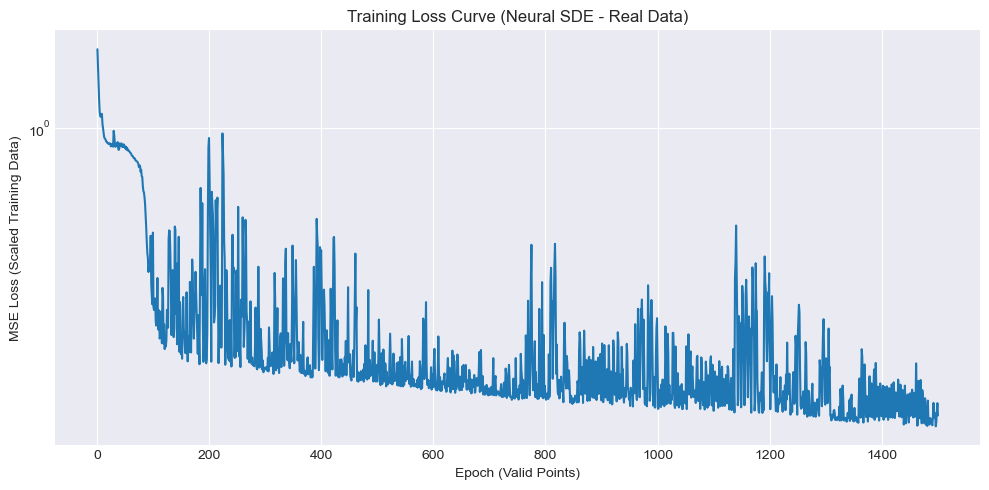

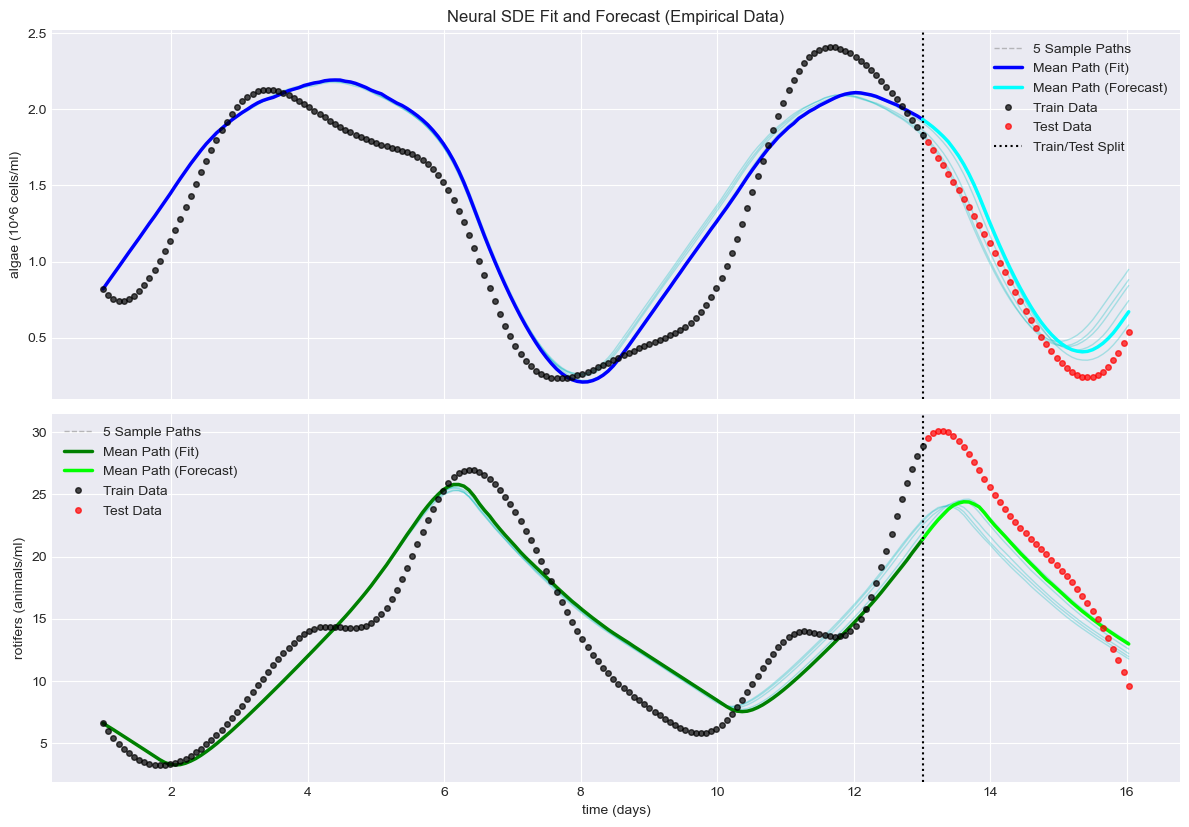

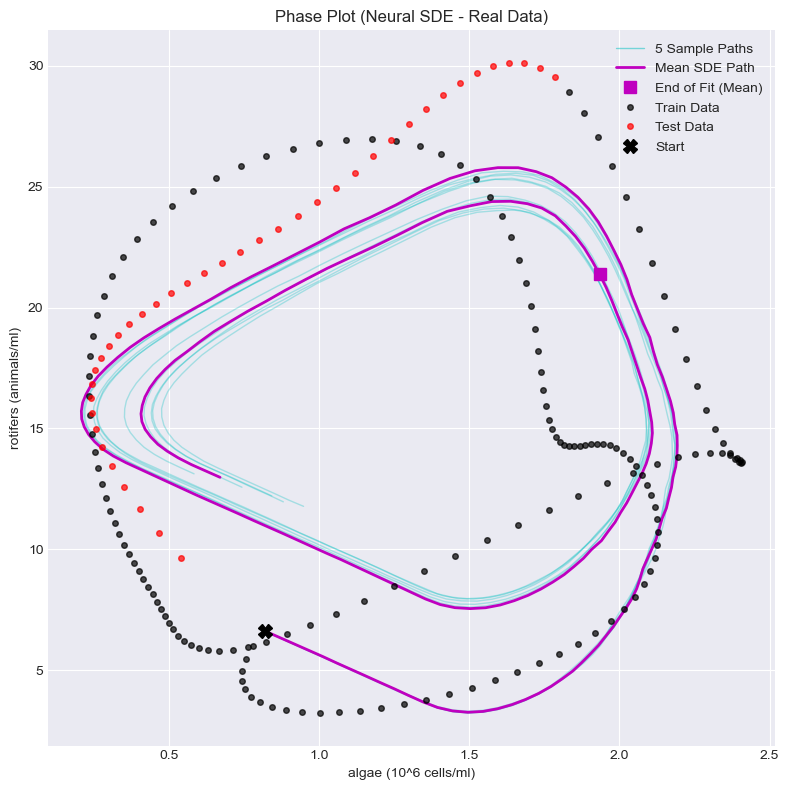

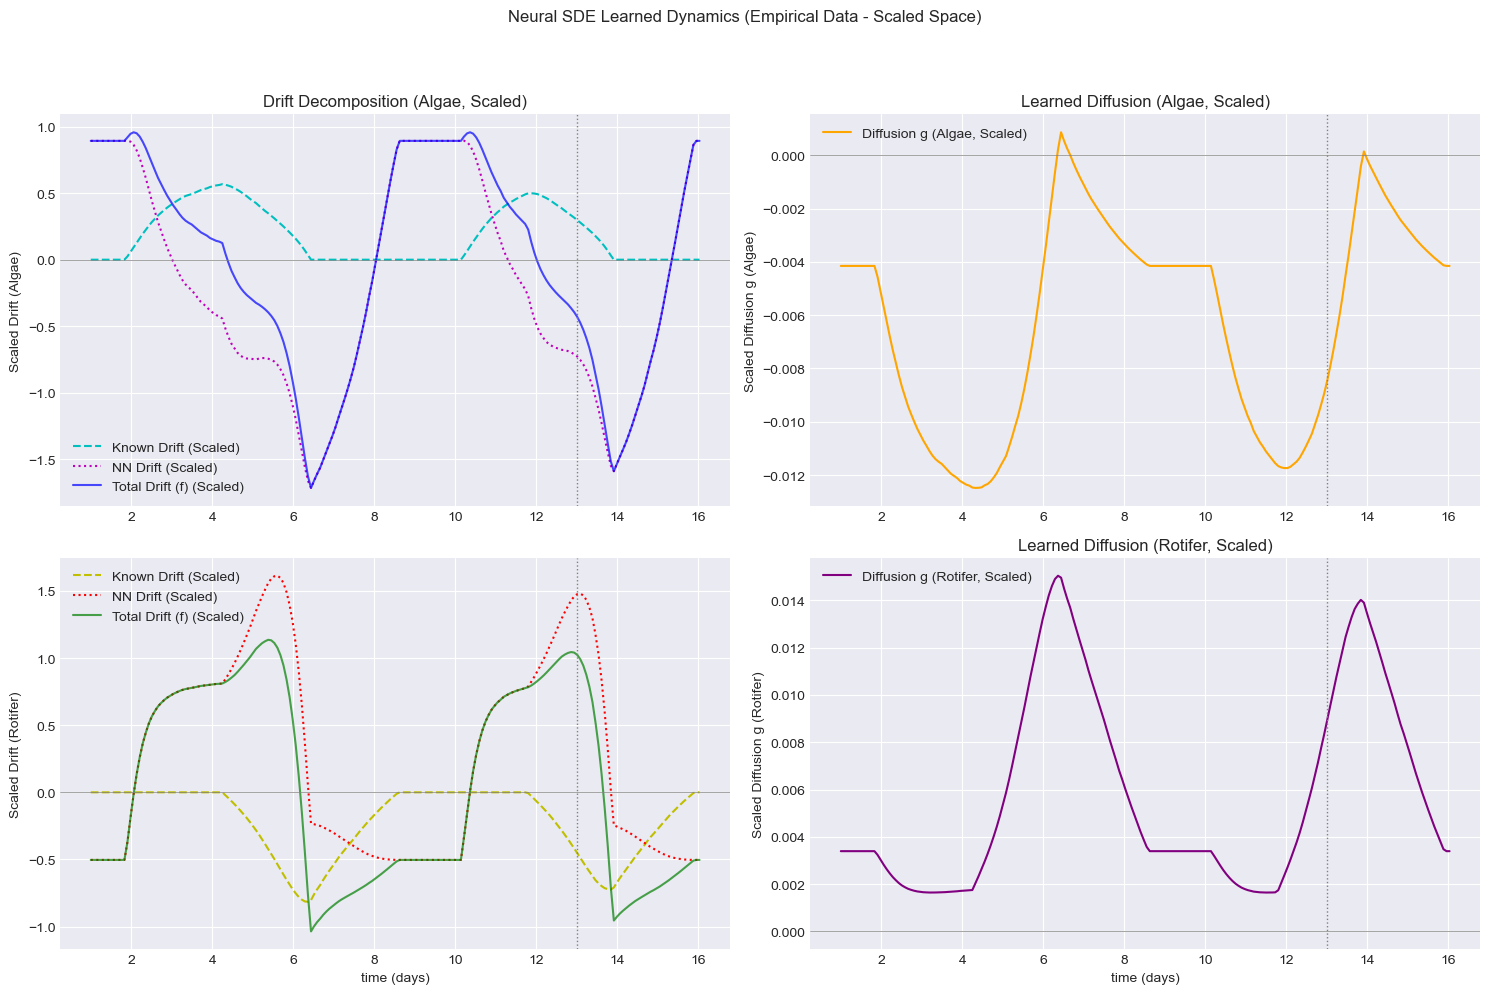


--- Script Finished ---


In [ ]:



def nrmse(y_true, y_pred):
    if y_true.ndim > 1 and y_true.shape[1] > 1: return np.nan
    if np.isnan(y_true).any() or np.isnan(y_pred).any(): return np.nan
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    data_range = np.max(y_true) - np.min(y_true)
    if data_range < 1e-8: return np.nan if rmse > 1e-8 else 0.0
    return rmse / data_range

def smape(y_true, y_pred, epsilon=1e-8):
    if np.isnan(y_true).any() or np.isnan(y_pred).any(): return np.nan
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    ratio = numerator / (denominator + epsilon)
    return np.mean(ratio) * 100.0


print("\n--- Evaluating Model Fit (Train) and Forecast (Test) ---")
sde_func.eval()


u_pred_full_scaled_np = np.full((N_POINTS, 2), np.nan) 
u_pred_full_np = np.full((N_POINTS, 2), np.nan)        
u_pred_train_np = np.full((n_train, 2), np.nan)        
u_pred_test_np = np.full((n_test, 2), np.nan)         
u_pred_samples_np = np.full((N_POINTS, N_PLOT_SAMPLES, 2), np.nan) 
u_pred_full_scaled = None 

with torch.no_grad():
    try:
        
        u0_batch = u0.unsqueeze(0)
        print("Generating mean prediction path (scaled)...")
        u_pred_full_scaled = torchsde.sdeint(sde_func, u0_batch, t_data, method=SDE_SOLVER_METHOD, dt=SDE_SOLVER_DT, names={'drift': 'f', 'diffusion': 'g'})
        u_pred_full_scaled = u_pred_full_scaled.squeeze(1) 
        u_pred_full_scaled_np = u_pred_full_scaled.cpu().numpy()

        
        print("Inverse transforming mean prediction...")
        if not (np.isnan(u_pred_full_scaled_np).any() or np.isinf(u_pred_full_scaled_np).any()):
            if 'scaler' in locals() and scaler is not None:
                u_pred_full_np = scaler.inverse_transform(u_pred_full_scaled_np) 
                u_pred_train_np = u_pred_full_np[:split_idx, :]
                u_pred_test_np = u_pred_full_np[split_idx:, :]
                print("Inverse transform successful.")
            else: print("Error: Scaler not found. Cannot inverse transform mean path."); u_pred_full_np.fill(np.nan)
        else: print("Error: Scaled mean prediction contains NaN/Inf."); u_pred_full_np.fill(np.nan)


        
        if not (np.isnan(u_pred_full_np).any() or np.isinf(u_pred_full_np).any()):
            print(f"Generating {N_PLOT_SAMPLES} sample paths (scaled)...")
            u0_samples = u0_batch.repeat(N_PLOT_SAMPLES, 1)
            u_pred_samples_scaled = torchsde.sdeint(sde_func, u0_samples, t_data, method=SDE_SOLVER_METHOD, dt=SDE_SOLVER_DT, names={'drift': 'f', 'diffusion': 'g'})
            
            u_pred_samples_scaled_np = u_pred_samples_scaled.cpu().numpy()

            print("Inverse transforming sample paths...")
            
            u_pred_samples_np = np.full_like(u_pred_samples_scaled_np, np.nan) 
            if not (np.isnan(u_pred_samples_scaled_np).any() or np.isinf(u_pred_samples_scaled_np).any()):
                 if 'scaler' in locals() and scaler is not None:
                     
                     original_shape = u_pred_samples_scaled_np.shape
                     reshaped_samples = u_pred_samples_scaled_np.reshape(-1, original_shape[-1])
                     inverted_samples = scaler.inverse_transform(reshaped_samples)
                     u_pred_samples_np = inverted_samples.reshape(original_shape) 
                     print("Sample path inverse transform successful.")
                 else: print("Error: Scaler not found. Cannot inverse transform samples.")
            else: print("Error: Scaled samples contain NaN/Inf.")
        else:
             print("Skipping sample path generation due to NaN/Inf in mean prediction.")


    except Exception as e:
        print(f"Error during evaluation (sdeint or inverse transform): {e}")
        print("Predictions may contain NaNs or evaluation failed.")


    
    print("\n--- Metrics Calculation (Original Scale, Mean Path vs True Data) ---")
    metrics_train = {}
    metrics_test = {}

    
    if not (np.isnan(u_pred_full_np).any() or np.isinf(u_pred_full_np).any()):
        
        u_train_algae = u_train_np_orig[:, 0]
        u_train_rotifer = u_train_np_orig[:, 1]
        u_test_algae = u_test_np_orig[:, 0]
        u_test_rotifer = u_test_np_orig[:, 1]
        
        u_pred_train_algae = u_pred_train_np[:, 0]
        u_pred_train_rotifer = u_pred_train_np[:, 1]
        u_pred_test_algae = u_pred_test_np[:, 0]
        u_pred_test_rotifer = u_pred_test_np[:, 1]

        
        
        metrics_train['MSE_algae'] = mean_squared_error(u_train_algae, u_pred_train_algae)
        metrics_train['MSE_rotifer'] = mean_squared_error(u_train_rotifer, u_pred_train_rotifer)
        metrics_train['MSE_total'] = mean_squared_error(u_train_np_orig, u_pred_train_np)
        metrics_train['RMSE_algae'] = np.sqrt(metrics_train['MSE_algae'])
        metrics_train['RMSE_rotifer'] = np.sqrt(metrics_train['MSE_rotifer'])
        metrics_train['RMSE_total'] = np.sqrt(metrics_train['MSE_total'])
        metrics_train['MAE_algae'] = mean_absolute_error(u_train_algae, u_pred_train_algae)
        metrics_train['MAE_rotifer'] = mean_absolute_error(u_train_rotifer, u_pred_train_rotifer)
        metrics_train['MAE_total'] = mean_absolute_error(u_train_np_orig, u_pred_train_np)
        metrics_train['NRMSE_algae'] = nrmse(u_train_algae, u_pred_train_algae)
        metrics_train['NRMSE_rotifer'] = nrmse(u_train_rotifer, u_pred_train_rotifer)
        metrics_train['sMAPE_algae'] = smape(u_train_algae, u_pred_train_algae)
        metrics_train['sMAPE_rotifer'] = smape(u_train_rotifer, u_pred_train_rotifer)
        metrics_train['R2_algae'] = r2_score(u_train_algae, u_pred_train_algae)
        metrics_train['R2_rotifer'] = r2_score(u_train_rotifer, u_pred_train_rotifer)
        metrics_train['R2_total'] = r2_score(u_train_np_orig, u_pred_train_np)
        
        metrics_test['MSE_algae'] = mean_squared_error(u_test_algae, u_pred_test_algae)
        metrics_test['MSE_rotifer'] = mean_squared_error(u_test_rotifer, u_pred_test_rotifer)
        metrics_test['MSE_total'] = mean_squared_error(u_test_np_orig, u_pred_test_np)
        metrics_test['RMSE_algae'] = np.sqrt(metrics_test['MSE_algae'])
        metrics_test['RMSE_rotifer'] = np.sqrt(metrics_test['MSE_rotifer'])
        metrics_test['RMSE_total'] = np.sqrt(metrics_test['MSE_total'])
        metrics_test['MAE_algae'] = mean_absolute_error(u_test_algae, u_pred_test_algae)
        metrics_test['MAE_rotifer'] = mean_absolute_error(u_test_rotifer, u_pred_test_rotifer)
        metrics_test['MAE_total'] = mean_absolute_error(u_test_np_orig, u_pred_test_np)
        metrics_test['NRMSE_algae'] = nrmse(u_test_algae, u_pred_test_algae)
        metrics_test['NRMSE_rotifer'] = nrmse(u_test_rotifer, u_pred_test_rotifer)
        metrics_test['sMAPE_algae'] = smape(u_test_algae, u_pred_test_algae)
        metrics_test['sMAPE_rotifer'] = smape(u_test_rotifer, u_pred_test_rotifer)
        metrics_test['R2_algae'] = r2_score(u_test_algae, u_pred_test_algae)
        metrics_test['R2_rotifer'] = r2_score(u_test_rotifer, u_pred_test_rotifer)
        metrics_test['R2_total'] = r2_score(u_test_np_orig, u_pred_test_np)

        
        print("\n--- Training Set Metrics (Fit Performance, Original Scale - Mean Path) ---")
        print(f"  Metric       |   Algae   |  Rotifer  |   Total   ")
        print(f"----------------------------------------------------")
        print(f"  MSE          | {metrics_train['MSE_algae']:<9.4f} | {metrics_train['MSE_rotifer']:<9.4f} | {metrics_train['MSE_total']:<9.4f}")
        print(f"  RMSE         | {metrics_train['RMSE_algae']:<9.4f} | {metrics_train['RMSE_rotifer']:<9.4f} | {metrics_train['RMSE_total']:<9.4f}")
        print(f"  MAE          | {metrics_train['MAE_algae']:<9.4f} | {metrics_train['MAE_rotifer']:<9.4f} | {metrics_train['MAE_total']:<9.4f}")
        print(f"  NRMSE (range)| {metrics_train['NRMSE_algae']:<9.4f} | {metrics_train['NRMSE_rotifer']:<9.4f} |    N/A    ")
        print(f"  sMAPE (%)    | {metrics_train['sMAPE_algae']:<9.2f} | {metrics_train['sMAPE_rotifer']:<9.2f} |    N/A    ")
        print(f"  R^2          | {metrics_train['R2_algae']:<9.4f} | {metrics_train['R2_rotifer']:<9.4f} | {metrics_train['R2_total']:<9.4f}")

        print("\n--- Test Set Metrics (Forecast Performance, Original Scale - Mean Path) ---")
        print(f"  Metric       |   Algae   |  Rotifer  |   Total   ")
        print(f"----------------------------------------------------")
        print(f"  MSE          | {metrics_test['MSE_algae']:<9.4f} | {metrics_test['MSE_rotifer']:<9.4f} | {metrics_test['MSE_total']:<9.4f}")
        print(f"  RMSE         | {metrics_test['RMSE_algae']:<9.4f} | {metrics_test['RMSE_rotifer']:<9.4f} | {metrics_test['RMSE_total']:<9.4f}")
        print(f"  MAE          | {metrics_test['MAE_algae']:<9.4f} | {metrics_test['MAE_rotifer']:<9.4f} | {metrics_test['MAE_total']:<9.4f}")
        print(f"  NRMSE (range)| {metrics_test['NRMSE_algae']:<9.4f} | {metrics_test['NRMSE_rotifer']:<9.4f} |    N/A    ")
        print(f"  sMAPE (%)    | {metrics_test['sMAPE_algae']:<9.2f} | {metrics_test['sMAPE_rotifer']:<9.2f} |    N/A    ")
        print(f"  R^2          | {metrics_test['R2_algae']:<9.4f} | {metrics_test['R2_rotifer']:<9.4f} | {metrics_test['R2_total']:<9.4f}")
        print("-" * 52)

    else:
        print("Skipping metrics calculation due to NaN/Inf in mean prediction.")

    
    if best_model_state:
        try:
            learned_params = torch.exp(sde_func.known_drift.log_params).cpu().numpy()
            print("\nLearned LV Parameters (Known Drift Component):")
            
            print(f"  alpha (Algae growth):    {learned_params[0]:<8.4f}")
            print(f"  beta (Algae predation):  {learned_params[1]:<8.4f}")
            print(f"  gamma (Rotifer death):   {learned_params[2]:<8.4f}")
            print(f"  delta (Rotifer growth):  {learned_params[3]:<8.4f}")
        except Exception as e: print(f"Could not retrieve learned parameters: {e}")
    else: print("\nSkipping learned parameter printout.")

    
    if u_pred_full_scaled is not None and not torch.isnan(u_pred_full_scaled).any():
        print("\nCalculating average dynamics magnitudes (scaled space)...")
        diffusion_magnitude_s = []
        drift_nn_magnitude_s = []
        drift_known_magnitude_s = []
        state_traj_scaled = u_pred_full_scaled 
        ts_eval = t_data
        for i in range(len(ts_eval)):
            t_i = ts_eval[i]; u_i_s = state_traj_scaled[i].unsqueeze(0)
            u_nonneg_i_s = torch.relu(u_i_s)
            with torch.no_grad(): 
                 g_val_s = sde_func.g(t_i, u_nonneg_i_s)
                 nn_f_val_s = sde_func.nn_drift(u_nonneg_i_s)
                 known_f_val_s = sde_func.known_drift(t_i, u_nonneg_i_s)
            diffusion_magnitude_s.append(torch.norm(g_val_s).item())
            drift_nn_magnitude_s.append(torch.norm(nn_f_val_s).item())
            drift_known_magnitude_s.append(torch.norm(known_f_val_s).item())
        print(f"  Avg Diffusion ||g|| (Scaled): {np.mean(diffusion_magnitude_s):.4f}")
        print(f"  Avg NN Drift ||NN_f|| (Scaled): {np.mean(drift_nn_magnitude_s):.4f}")
        print(f"  Avg Known Drift ||Known_f|| (Scaled): {np.mean(drift_known_magnitude_s):.4f}")
    else: print("Skipping dynamics magnitude calculation due to invalid scaled predictions.")



print("\n--- Generating Plots ---")
plt.style.use('seaborn-v0_8-darkgrid')
split_time = t_train_np[-1] if 't_train_np' in locals() and len(t_train_np) > 0 else None


plt.figure(1, figsize=(10, 5))
if 'losses' in locals() and losses and not np.all(np.isnan(losses)):
    valid_losses = [l for l in losses if not np.isnan(l)]
    if valid_losses: plt.plot(range(1, len(valid_losses) + 1), valid_losses); plt.xlabel("Epoch (Valid Points)")
    else: plt.xlabel("Epoch")
else: plt.xlabel("Epoch")
plt.ylabel("MSE Loss (Scaled Training Data)"); plt.title("Training Loss Curve (Neural SDE - Real Data)")
plt.yscale('log'); plt.grid(True); plt.tight_layout()



fig_ts, axs_ts = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
fit_color_algae = 'blue'; forecast_color_algae = 'cyan'
fit_color_rotifer = 'green'; forecast_color_rotifer = 'lime'
plot_mean_ok = not np.isnan(u_pred_full_np).any() 
plot_samples_ok = not np.isnan(u_pred_samples_np).any() 

if plot_mean_ok:
    t_forecast_plot = np.concatenate(([t_train_np[-1]], t_test_np))
    u_pred_forecast_plot_algae = np.concatenate(([u_pred_train_np[-1, 0]], u_pred_test_np[:, 0]))
    u_pred_forecast_plot_rotifer = np.concatenate(([u_pred_train_np[-1, 1]], u_pred_test_np[:, 1]))
else: print("Skipping prediction line plotting in Time Series plot due to NaNs.")


if plot_samples_ok:
    for i in range(N_PLOT_SAMPLES):
        axs_ts[0].plot(t_data_np_full, u_pred_samples_np[:, i, 0], 'c-', linestyle='-', alpha=0.3, linewidth=1)
        axs_ts[1].plot(t_data_np_full, u_pred_samples_np[:, i, 1], 'c-', linestyle='-', alpha=0.3, linewidth=1)
    axs_ts[0].plot([], [], color='gray', linestyle='--', alpha=0.5, linewidth=1, label=f'{N_PLOT_SAMPLES} Sample Paths')
    axs_ts[1].plot([], [], color='gray', linestyle='--', alpha=0.5, linewidth=1, label=f'{N_PLOT_SAMPLES} Sample Paths')
else: print("Skipping sample path plotting due to NaNs.")


if plot_mean_ok:
    axs_ts[0].plot(t_train_np, u_pred_train_np[:, 0], color=fit_color_algae, linestyle='-', linewidth=2.5, label='Mean Path (Fit)')
    axs_ts[0].plot(t_forecast_plot, u_pred_forecast_plot_algae, color=forecast_color_algae, linestyle='-', linewidth=2.5, label='Mean Path (Forecast)')
    axs_ts[1].plot(t_train_np, u_pred_train_np[:, 1], color=fit_color_rotifer, linestyle='-', linewidth=2.5, label='Mean Path (Fit)')
    axs_ts[1].plot(t_forecast_plot, u_pred_forecast_plot_rotifer, color=forecast_color_rotifer, linestyle='-', linewidth=2.5, label='Mean Path (Forecast)')


axs_ts[0].plot(t_train_np, u_train_np_orig[:, 0], 'ko', markersize=4, alpha=0.7, label='Train Data')
axs_ts[0].plot(t_test_np, u_test_np_orig[:, 0], 'ro', markersize=4, alpha=0.7, label='Test Data')
axs_ts[1].plot(t_train_np, u_train_np_orig[:, 1], 'ko', markersize=4, alpha=0.7, label='Train Data')
axs_ts[1].plot(t_test_np, u_test_np_orig[:, 1], 'ro', markersize=4, alpha=0.7, label='Test Data')

if split_time is not None: axs_ts[0].axvline(split_time, color='black', linestyle=':', linewidth=1.5, label='Train/Test Split')
axs_ts[0].set_ylabel(prey_col); axs_ts[0].set_title("Neural SDE Fit and Forecast (Empirical Data)")
axs_ts[0].legend(loc='best'); axs_ts[0].grid(True)
if split_time is not None: axs_ts[1].axvline(split_time, color='black', linestyle=':', linewidth=1.5)
axs_ts[1].set_ylabel(predator_col); axs_ts[1].set_xlabel(time_col)
axs_ts[1].legend(loc='best'); axs_ts[1].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])



plt.figure(3, figsize=(8, 8))

if plot_samples_ok:
    for i in range(N_PLOT_SAMPLES):
        plt.plot(u_pred_samples_np[:, i, 0], u_pred_samples_np[:, i, 1], 'c-', alpha=0.3, linewidth=1)
    plt.plot([], [], 'c-', alpha=0.5, linewidth=1, label=f'{N_PLOT_SAMPLES} Sample Paths')

if plot_mean_ok:
    plt.plot(u_pred_full_np[:, 0], u_pred_full_np[:, 1], 'm-', linewidth=2, label='Mean SDE Path')
    if not np.isnan(u_pred_train_np).any():
         plt.plot(u_pred_train_np[-1, 0], u_pred_train_np[-1, 1], 'ms', markersize=8, label='End of Fit (Mean)')
else: print("Skipping mean path plotting in phase plot due to NaNs.")

plt.plot(u_train_np_orig[:, 0], u_train_np_orig[:, 1], 'ko', markersize=4, alpha=0.7, label='Train Data')
plt.plot(u_test_np_orig[:, 0], u_test_np_orig[:, 1], 'ro', markersize=4, alpha=0.7, label='Test Data')

if 'scaler' in locals() and not np.isnan(u0.cpu().numpy()).any():
    try: u0_orig = scaler.inverse_transform(u0.cpu().numpy().reshape(1,-1))[0]; plt.plot(u0_orig[0], u0_orig[1], 'kX', markersize=10, label='Start')
    except: pass 
plt.xlabel(prey_col); plt.ylabel(predator_col); plt.title("Phase Plot (Neural SDE - Real Data)")
plt.legend(); plt.grid(True); plt.tight_layout()



print("\n--- Visualizing Learned Dynamics (Full Trajectory, Scaled Space) ---")

if u_pred_full_scaled is not None and not (torch.isnan(u_pred_full_scaled).any() or torch.isinf(u_pred_full_scaled).any()):
    with torch.no_grad():
        state_traj_scaled = u_pred_full_scaled
        known_drift_s = torch.zeros_like(state_traj_scaled)
        nn_drift_s = torch.zeros_like(state_traj_scaled)
        diffusion_output_dim = sde_func.nn_diffusion.final_output_dim
        nn_diffusion_s = torch.zeros(state_traj_scaled.shape[0], diffusion_output_dim).to(device)

        for i in range(len(t_data)):
            t_i = t_data[i]; u_i_s = state_traj_scaled[i].unsqueeze(0)
            u_nonneg_i_s = torch.relu(u_i_s)
            known_drift_s[i] = sde_func.known_drift(t_i, u_nonneg_i_s).squeeze(0)
            nn_drift_s[i] = sde_func.nn_drift(u_nonneg_i_s).squeeze(0)
            nn_diffusion_s[i] = sde_func.g(t_i, u_nonneg_i_s).squeeze(0)

        known_drift_np_s = known_drift_s.cpu().numpy()
        nn_drift_np_s = nn_drift_s.cpu().numpy()
        total_drift_np_s = known_drift_np_s + nn_drift_np_s
        nn_diffusion_np_s = nn_diffusion_s.cpu().numpy()

    
    fig_decomp, axs_decomp = plt.subplots(2, 2, figsize=(15, 10))
    
    axs_decomp[0, 0].plot(t_data_np_full, known_drift_np_s[:, 0], 'c--', label='Known Drift (Scaled)')
    axs_decomp[0, 0].plot(t_data_np_full, nn_drift_np_s[:, 0], 'm:', label='NN Drift (Scaled)')
    axs_decomp[0, 0].plot(t_data_np_full, total_drift_np_s[:, 0], 'b-', alpha=0.7, label='Total Drift (f) (Scaled)')
    if split_time is not None: axs_decomp[0, 0].axvline(split_time, color='gray', ls=':', lw=1)
    axs_decomp[0, 0].set_ylabel("Scaled Drift (Algae)"); axs_decomp[0, 0].legend(); axs_decomp[0, 0].set_title("Drift Decomposition (Algae, Scaled)")
    axs_decomp[0, 0].axhline(0, color='gray', lw=0.5); axs_decomp[0, 0].grid(True)
    axs_decomp[1, 0].plot(t_data_np_full, known_drift_np_s[:, 1], 'y--', label='Known Drift (Scaled)')
    axs_decomp[1, 0].plot(t_data_np_full, nn_drift_np_s[:, 1], 'r:', label='NN Drift (Scaled)')
    axs_decomp[1, 0].plot(t_data_np_full, total_drift_np_s[:, 1], 'g-', alpha=0.7, label='Total Drift (f) (Scaled)')
    if split_time is not None: axs_decomp[1, 0].axvline(split_time, color='gray', ls=':', lw=1)
    axs_decomp[1, 0].set_ylabel("Scaled Drift (Rotifer)"); axs_decomp[1, 0].set_xlabel(time_col)
    axs_decomp[1, 0].legend(); axs_decomp[1, 0].axhline(0, color='gray', lw=0.5); axs_decomp[1, 0].grid(True)

    
    if NOISE_TYPE == 'diagonal' and nn_diffusion_np_s.shape[1] == 2:
        axs_decomp[0, 1].plot(t_data_np_full, nn_diffusion_np_s[:, 0], 'orange', label='Diffusion g (Algae, Scaled)')
        axs_decomp[0, 1].set_ylabel("Scaled Diffusion g (Algae)"); axs_decomp[0, 1].set_title("Learned Diffusion (Algae, Scaled)")
        axs_decomp[1, 1].plot(t_data_np_full, nn_diffusion_np_s[:, 1], 'purple', label='Diffusion g (Rotifer, Scaled)')
        axs_decomp[1, 1].set_ylabel("Scaled Diffusion g (Rotifer)"); axs_decomp[1, 1].set_title("Learned Diffusion (Rotifer, Scaled)")
    
    else: print(f"Plotting for diffusion shape {nn_diffusion_np_s.shape} not fully implemented.")

    if split_time is not None: axs_decomp[0, 1].axvline(split_time, color='gray', ls=':', lw=1)
    axs_decomp[0, 1].legend(); axs_decomp[0, 1].axhline(0, color='gray', lw=0.5); axs_decomp[0, 1].grid(True)
    if NOISE_TYPE != 'scalar':
         if split_time is not None: axs_decomp[1, 1].axvline(split_time, color='gray', ls=':', lw=1)
         axs_decomp[1, 1].set_xlabel(time_col); axs_decomp[1, 1].legend(); axs_decomp[1, 1].axhline(0, color='gray', lw=0.5); axs_decomp[1, 1].grid(True)

    plt.suptitle("Neural SDE Learned Dynamics (Empirical Data - Scaled Space)", y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
else:
    print("Skipping dynamics decomposition plot due to invalid scaled predictions.")



if plt.get_fignums():
    plt.show()
else:
    print("No plots were generated.")

print("\n--- Script Finished ---")